In [1]:
import numpy as np
import requests
import urllib
import pandas as pd
import warnings
import holidays
from prophet import Prophet
from prophet.plot import add_changepoints_to_plot
from prophet.plot import plot_plotly, plot_components_plotly
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
from plotly import graph_objs as go
from matplotlib import pyplot as plt

In [2]:
init_notebook_mode(connected = True)
warnings.filterwarnings('ignore')

## Tratamento do gráfico


In [3]:
def plotly_df(df, title = ''):
    data = []
    
    for column in df.columns:
        trace = go.Scatter(
            x = df.index,
            y = df[column],
            mode = 'lines',
            name = column
        )
        data.append(trace)

    fig = {'data': data, 'layout': {'title': title}}
    iplot(fig, show_link=False)

## Conversão de uma consulta PromQL em Pandas DataFrame


In [4]:
def get_data(query:str, url:str) -> pd.DataFrame:
    params = {'query': query}   
    url_encoded_query = urllib.parse.urlencode(params,safe='+')
    res = requests.get(url, params=url_encoded_query)
    out = res.json()
    results = out['data']['result']
    valueslist = []
    
    for result in results:
        valueslist.append(result['values'])
    if not valueslist:
        return None

    flattened = [val for sublist in valueslist for val in sublist]
    
    df = pd.DataFrame(flattened)
    df.columns=["ds","y"]
    df["ds"] =  pd.to_datetime(df["ds"],utc=False,unit='s')
    
    return df

## Obtendo dados pela API do Prometheus


In [5]:
# query='rate(node_disk_read_bytes_total{job="node",instance="node-exporter:9100",device=~"vda"}[30m])[90d:30m]'
query='rate(http_request_duration_seconds_sum{code="200", route="/api/partners"}[10m])[7d:10m]'
# query='rate(http_request_duration_seconds_sum{code="200"}[1m])[30d:1m]'
url= "http://localhost:9090/api/v1/query"
df = get_data(query, url)

## Adicionando características prévias ao nosso modelo (evento inesperado)


In [6]:
events = pd.DataFrame({
  'holiday': 'playoff',
  'ds': pd.to_datetime(['2023-09-14', '2023-09-15', '2023-09-16']),
  'lower_window': 0,
  'upper_window': 1,
})

## Construção do modelo


In [7]:
model = Prophet(
    changepoint_prior_scale=0.05,
    changepoint_range=1,
    daily_seasonality=True,
    weekly_seasonality=False,
    yearly_seasonality=False,
    holidays=events,
    holidays_prior_scale=0.001
)

## Adicionando feriados nacionais após a construção do modelo


In [8]:
model.add_country_holidays(country_name='BR')
holidays.BR(years=[2023,2023]).items()

dict_items([(datetime.date(2023, 1, 1), 'Confraternização Universal'), (datetime.date(2023, 4, 7), 'Sexta-feira Santa'), (datetime.date(2023, 4, 21), 'Tiradentes'), (datetime.date(2023, 5, 1), 'Dia do Trabalhador'), (datetime.date(2023, 9, 7), 'Independência do Brasil'), (datetime.date(2023, 10, 12), 'Nossa Senhora Aparecida'), (datetime.date(2023, 11, 2), 'Finados'), (datetime.date(2023, 11, 15), 'Proclamação da República'), (datetime.date(2023, 12, 25), 'Natal')])

## Treinando o modelo


In [9]:
model.fit(df)

future = model.make_future_dataframe(periods=10, freq='10min')
forecast = model.predict(future)
forecast.head()

17:51:21 - cmdstanpy - INFO - Chain [1] start processing
17:51:21 - cmdstanpy - INFO - Chain [1] done processing


,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,Confraternização Universal,Confraternização Universal_lower,Confraternização Universal_upper,Dia do Trabalhador,...,holidays,holidays_lower,holidays_upper,playoff,playoff_lower,playoff_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
0,2023-09-14 21:00:00,0.000059,-0.000191,0.000354,0.000059,0.000059,0.0,0.0,0.0,0.0,...,-1.434017e-07,-1.434017e-07,-1.434017e-07,-1.434017e-07,-1.434017e-07,-1.434017e-07,0.0,0.0,0.0,0.000086
1,2023-09-14 21:10:00,0.000058,-0.000195,0.000348,0.000058,0.000058,0.0,0.0,0.0,0.0,...,-1.434017e-07,-1.434017e-07,-1.434017e-07,-1.434017e-07,-1.434017e-07,-1.434017e-07,0.0,0.0,0.0,0.000079
2,2023-09-14 21:20:00,0.000058,-0.000174,0.000356,0.000058,0.000058,0.0,0.0,0.0,0.0,...,-1.434017e-07,-1.434017e-07,-1.434017e-07,-1.434017e-07,-1.434017e-07,-1.434017e-07,0.0,0.0,0.0,0.000073
3,2023-09-14 21:30:00,0.000058,-0.000197,0.000341,0.000058,0.000058,0.0,0.0,0.0,0.0,...,-1.434017e-07,-1.434017e-07,-1.434017e-07,-1.434017e-07,-1.434017e-07,-1.434017e-07,0.0,0.0,0.0,0.000067
4,2023-09-14 21:40:00,0.000058,-0.000202,0.000301,0.000058,0.000058,0.0,0.0,0.0,0.0,...,-1.434017e-07,-1.434017e-07,-1.434017e-07,-1.434017e-07,-1.434017e-07,-1.434017e-07,0.0,0.0,0.0,0.000062


## Plotando os pontos de anomalias que ultrapassaram o limite


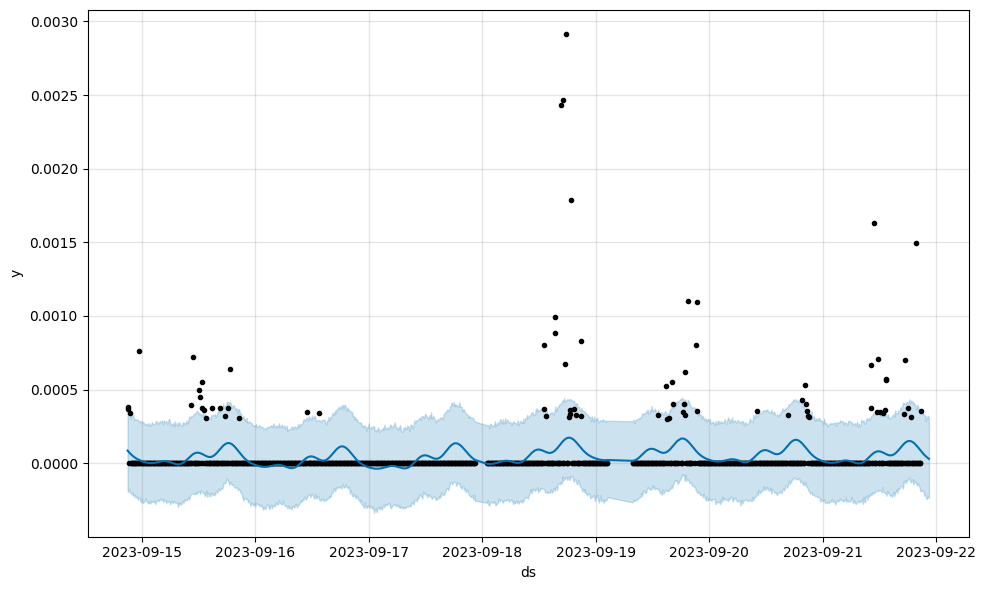

In [10]:
figsize=(10, 6)
fig = plt.figure(facecolor='w', figsize=figsize)
ax = fig.add_subplot(111)
fig = model.plot(forecast,ax=ax)


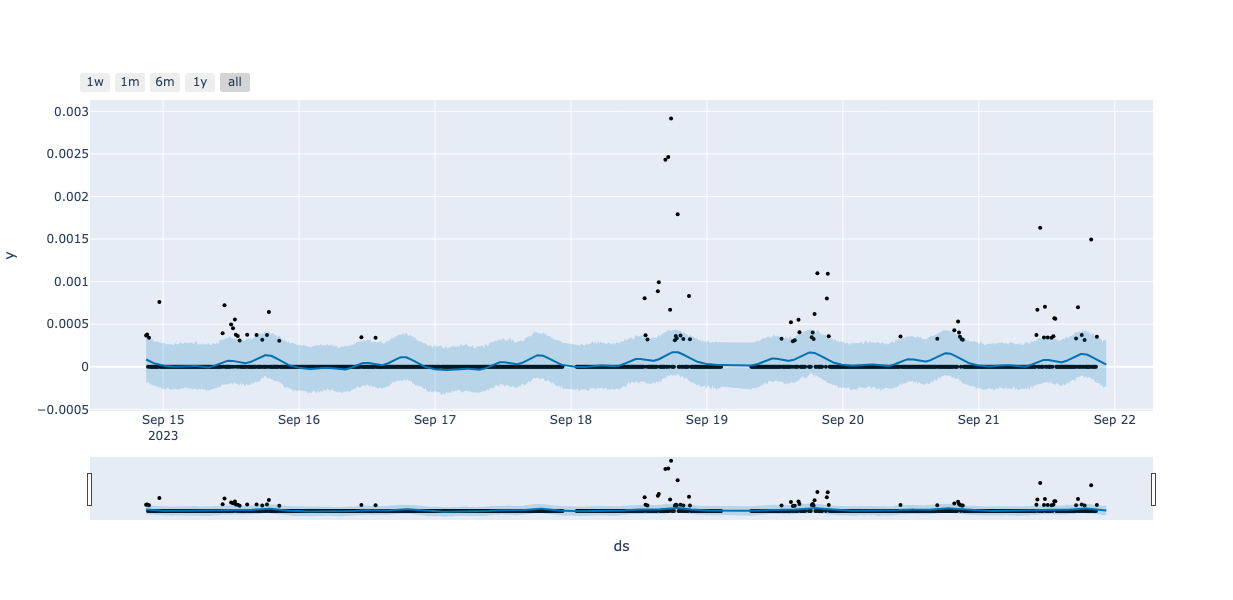

In [11]:
plot_plotly(model, forecast)

## Pontos de mundanças onde o prophet faz a detecção das tendências


In [12]:
threshold=0.01
signif_changepoints = model.changepoints[np.abs(np.nanmean(model.params['delta'], axis=0)) >= threshold]
print("changepoints=\n",model.changepoints)

changepoints=
 38    2023-09-15 03:20:00
76    2023-09-15 09:40:00
115   2023-09-15 16:10:00
153   2023-09-15 22:30:00
191   2023-09-16 04:50:00
229   2023-09-16 11:10:00
267   2023-09-16 17:30:00
306   2023-09-17 00:00:00
344   2023-09-17 06:30:00
382   2023-09-17 12:50:00
420   2023-09-17 19:10:00
458   2023-09-18 03:50:00
497   2023-09-18 10:20:00
535   2023-09-18 16:40:00
573   2023-09-18 23:00:00
611   2023-09-19 10:30:00
649   2023-09-19 16:50:00
688   2023-09-20 00:20:00
726   2023-09-20 06:40:00
764   2023-09-20 13:00:00
802   2023-09-20 19:20:00
840   2023-09-21 01:40:00
879   2023-09-21 08:10:00
917   2023-09-21 14:30:00
955   2023-09-21 20:50:00
Name: ds, dtype: datetime64[ns]
